# Proyecto de Serie Temporal Alternativa ARIMA

In [39]:
# Your code here
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf


### Paso 1: Carga del conjunto de datos

In [5]:
# URL del archivo CSV
url = 'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'

# Leer el archivo CSV desde la URL
data_sales = pd.read_csv(url)

# Ruta de destino
ruta_destino = '/workspaces/Proyecto-Serie-Temporal-Alternativa/data/raw/sales.csv'

# Crear el directorio si no existe
os.makedirs(os.path.dirname(ruta_destino), exist_ok=True)

# Guardar el DataFrame en la ruta especificada con una copia de la data original
data_sales.to_csv(ruta_destino, index=False)

print(f'Archivo guardado en: {ruta_destino}')

Archivo guardado en: /workspaces/Proyecto-Serie-Temporal-Alternativa/data/raw/sales.csv


In [6]:
data_sales.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [7]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [8]:
# Transformamos a objeto Datetime
data_sales['fecha'] = pd.to_datetime(data_sales['date'], format='%Y-%m-%d %H:%M:%S.%f').dt.date
data_sales['fecha']=pd.to_datetime(data_sales['fecha'])
data_sales.head()

,date,sales,fecha
0,2022-09-03 17:10:08.079328,55.292157,2022-09-03
1,2022-09-04 17:10:08.079328,53.803211,2022-09-04
2,2022-09-05 17:10:08.079328,58.141693,2022-09-05
3,2022-09-06 17:10:08.079328,64.530899,2022-09-06
4,2022-09-07 17:10:08.079328,66.013633,2022-09-07


In [9]:

col=['fecha','sales']
total_sales=data_sales[col]
total_sales=total_sales.set_index('fecha')
total_sales.info()
total_sales.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-09-03 to 2023-09-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


,sales
fecha,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


### Paso 2: Construye y analiza la serie temporal

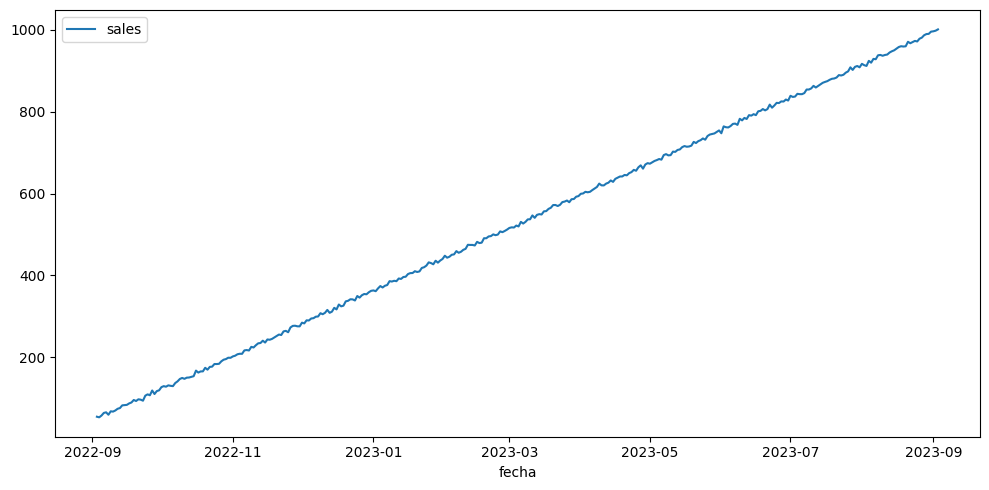

In [10]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_sales)

plt.tight_layout()

plt.show()

Descomposición de la serie

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

periodo=12
decomposition = seasonal_decompose(total_sales,period=periodo)
decomposition

- Análisis de Tendencia

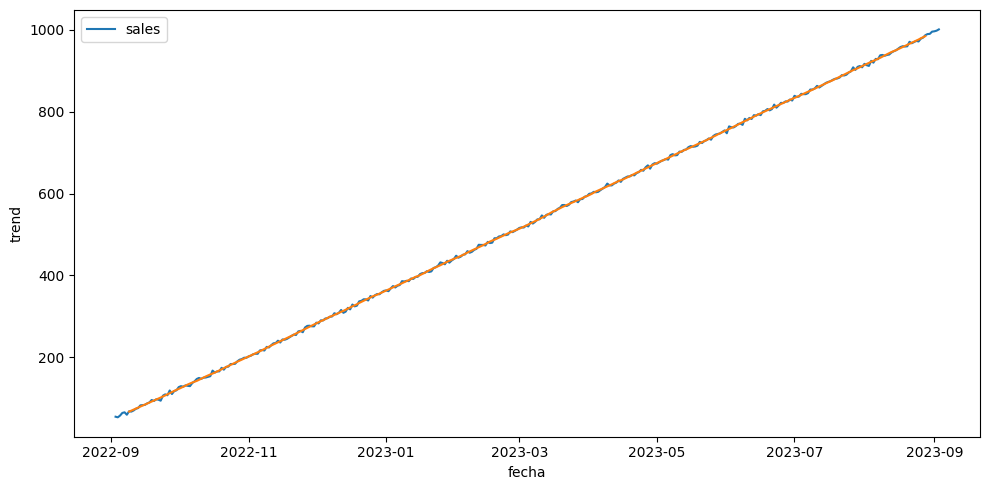

In [27]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_sales)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Evidenciamos una tendencia ascendente

* Análisis de la estacionalidad

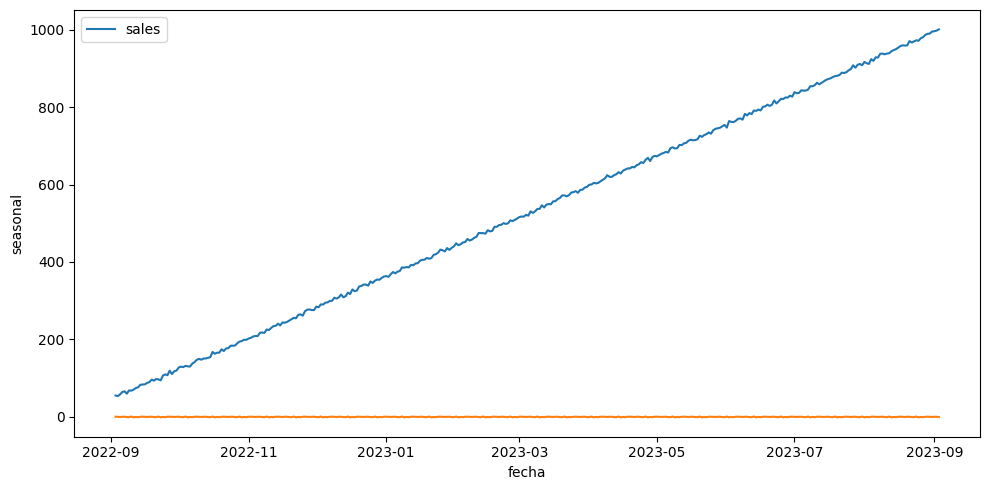

In [28]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_sales)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

No se evidencia estacionalidad de la serie, para evaluar la estacionalidad de la serie temporal de mejor manera aplicamos Prueba de Dickey-Fuller

In [29]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados test Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(total_sales)

Resultados test Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Evidenciamos que el p-value es mayor a 0.05 por tanto determinamos que no es estacionaria.

* Análisis de la variabilidad

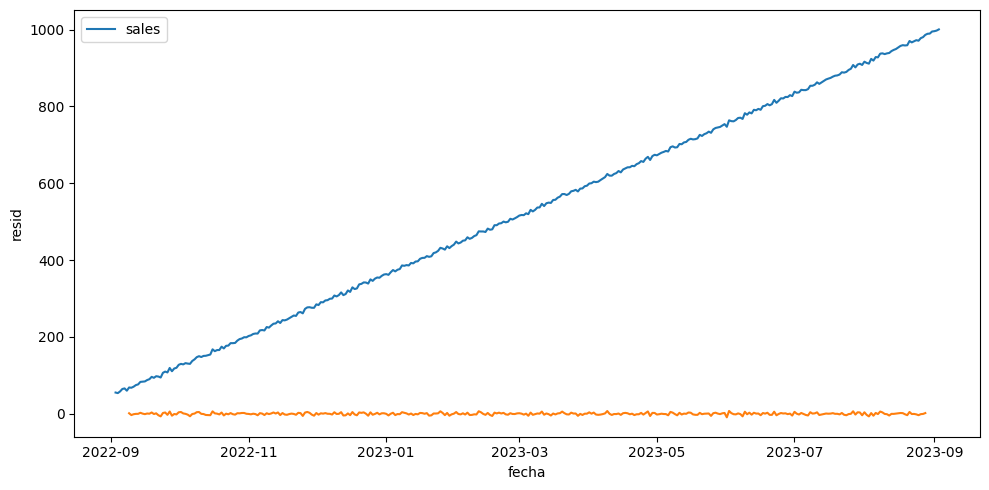

In [30]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = total_sales)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Evidenciamos una baja variabilidad

* Análisis de autocorrelación

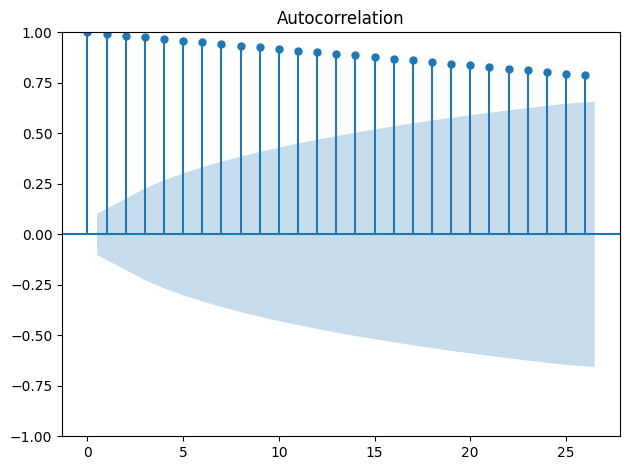

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(total_sales)

plt.tight_layout()

plt.show()

### Paso 3: Entrena un ARIMA

 Para optimizar al máximo lso resultados transformamos la serie en estacionaria

In [32]:
ts_stationary = total_sales.diff().dropna()

test_stationarity(ts_stationary)

Resultados test Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [33]:
# Dividimos conjunto de train y Test
from sklearn.model_selection import train_test_split

# Asigna la serie temporal a la variable X
X = ts_stationary

# Divide la serie temporal en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(X))  # 80% para entrenamiento
test_size = len(X) - train_size  # 20% para prueba

X_train, X_test = train_test_split(X, train_size=train_size, test_size=test_size, shuffle=False)
X_train.head()

,sales
fecha,
2022-09-04,-1.488946
2022-09-05,4.338482
2022-09-06,6.389205
2022-09-07,1.482734
2022-09-08,-5.931768


In [34]:
import pmdarima
from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.120, Time=1.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=0.91 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.48 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=1.53 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.38 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.434, Time=1.19 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.37 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.24 sec
 ARIMA(1,0,1)(1,0,0)[12] inte

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Fri, 20 Sep 2024   AIC                           1839.553
Time:                        20:42:54   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Paso 4: Predice con el conjunto de test

In [36]:
forecast = model.predict(12)
forecast

2023-09-04    1.675366
2023-09-05    2.673520
2023-09-06    2.591621
2023-09-07    2.598341
2023-09-08    2.597789
2023-09-09    2.597834
2023-09-10    2.597831
2023-09-11    2.597831
2023-09-12    2.597831
2023-09-13    2.597831
2023-09-14    2.597831
2023-09-15    2.597831
Freq: D, dtype: float64

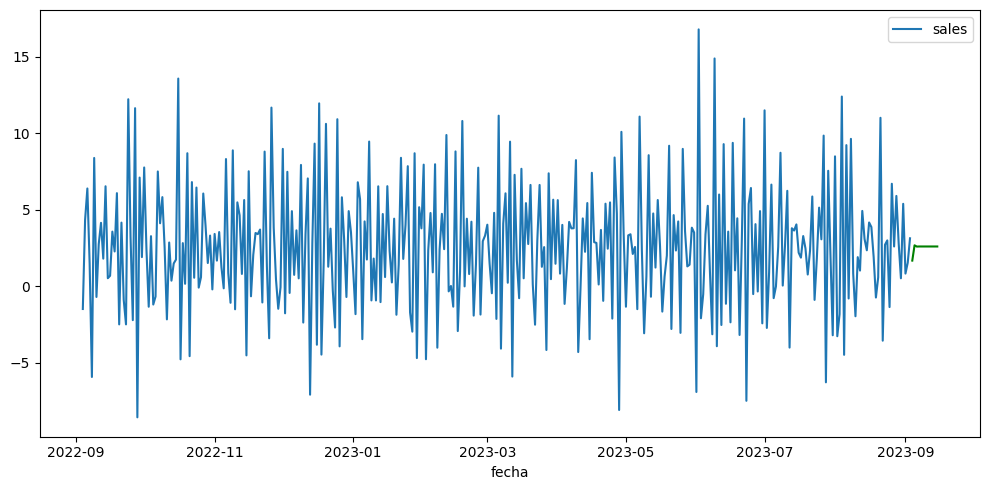

In [37]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [40]:
y_true = np.array([X_test])  # df de valores reales
y_pred = np.array([forecast])  # df de valores predichos

mse = np.mean((y_true - y_pred) ** 2)
print("MSE:", mse)

raiz_mse = np.sqrt(mse)
print("Raiz_MSE:", raiz_mse)

mae = np.mean(np.abs(y_true - y_pred))
print("MAE:", mae)

MSE: 16.655598560756697
Raiz_MSE: 4.081127118916624
MAE: 3.12930112289827


### Paso 5: Guarda el modelo

In [43]:
model_path = '/workspaces/Proyecto-Serie-Temporal-Alternativa/models/model_ARIMA_sales.joblib'
# Save the model
joblib.dump(model, model_path)

print(f"Modelo guardado en {model_path}")

Modelo guardado en /workspaces/Proyecto-Serie-Temporal-Alternativa/models/model_ARIMA_sales.joblib
